<a href="https://colab.research.google.com/github/s-choung/CER_ML/blob/main/CERML_FI_iGAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from IPython.display import Image
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pickle

tick_font_size = 15
label_font_size = 20
title_font_size = 20
tick_font_style = fm.FontProperties(fname='./segoeui.ttf',size=tick_font_size) # 폰트는 원하는 폰트로 바꿔주세용
label_font_style = fm.FontProperties(fname='./segoeui.ttf',size=label_font_size)
title_font_style = fm.FontProperties(fname='./segoeui.ttf',size=title_font_size)

file_select='./ads_final_2.xlsx'

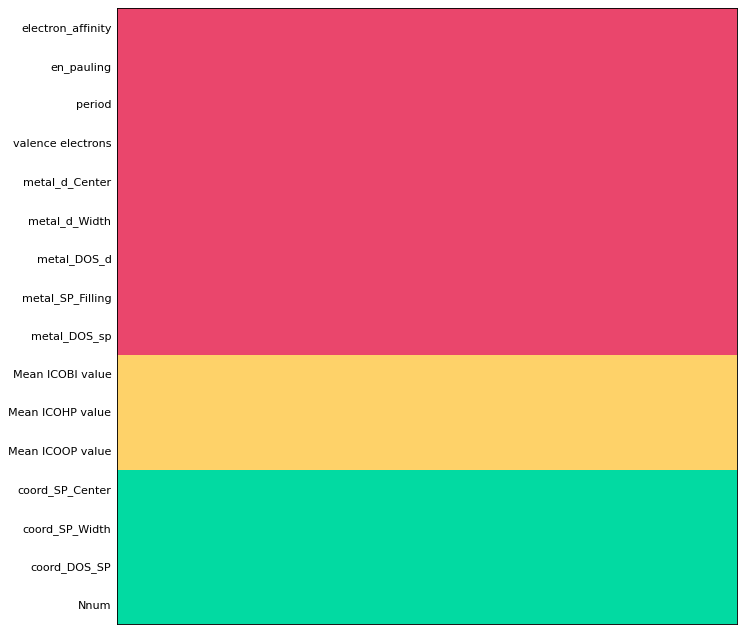

In [29]:
import matplotlib.patches as mpatches
df = pd.read_excel('./ads_final_2.xlsx')

# Color 설정
color_a = '#EA466C'
color_b = '#FED269'
color_c = '#02DAA2'


# Step 3: 'M' 열 제거
df = df.drop('M', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.
df = df.drop('index', axis=1)  
df = df.drop('G(Cl)', axis=1)  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.

feature_names = df.columns

# Create the color list
colors = [color_a]*9 + [color_b]*3 + [color_c]*4 # 앞에서부터 원하는 범위까지 설정해주면 됨.

# 각 feature별로 칼라가 원하는대로 설정됐는지 확인

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

for i, color in enumerate(colors):
    rect = mpatches.Rectangle((0, i), 1, 1, facecolor=color)
    ax.add_patch(rect)

ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='x', which='both', bottom=False, top=False)

ax.set_yticks([i + 0.5 for i in range(len(colors))], minor=True)
ax.set_yticklabels(feature_names, minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', which='both', left=False, right=False)
ax.invert_yaxis()

plt.show()

feature_colors = {name: color for name, color in zip(feature_names, colors)}

In [30]:
# iGAM model 구현
"""
Intelligbible models for regression, from Lou, Caruana and Gehrke
(doi: 10.1145/2339530.2339556).

"""
import itertools as it
import numpy as np
from sklearn.tree import DecisionTreeRegressor


class BoostedBaggedTreeGAM:
    """iGAM for inteliigible models.

    Attributes:
        model (dict): Dictionary containing constituent trees of model.
        m_boost (int): Number of iterations for gradient boosting.
        n_leaves (int): Number of leaves in each tree.
        n_trees (int): Number of bagged trees for each shaping function.

    """

    def __init__(self, m_boost, n_leaves=2, n_trees=100, pairwise=0):
        """

        Args:
            m_boost (int): Number of iterations for gradient boosting.
            n_leaves (int): Number of leaves in each tree.
            n_trees (int): Number of bagged trees for each shaping function.
            pairwise(int): Numer of pairwise interactions to include.

        """
        self.model = {}
        self.pairwise = pairwise
        self.pairwise_model = {}
        self.pairwise_inds = {}
        self.m_boost = m_boost
        self.n_leaves = n_leaves
        self.n_trees = n_trees
        self.y_avg = None

    def fit(self, x_train, y_train):
        """Train model.

        Args:
            x_train (obj): (n, d) NumPy array containing training input
            samples.
            y_train (obj): (n, 1) Numpy vector containing target values.

        """
        self.y_avg = np.mean(y_train)
        n_samples, d_features = x_train.shape
        # build model dictionary
        for j in range(d_features):
            self.model[j] = []

        # fill model dictionary with decision trees
        for _ in range(self.m_boost):
            for j in range(d_features):
                bagged_trees = []
                for _ in range(self.n_trees):
                    # bootstrap sampling
                    ind = np.random.randint(n_samples,
                                            size=n_samples)
                    x_sample = x_train[ind, :]
                    # boosting
                    y_sample = (y_train[ind, :].reshape(-1, 1)
                                - self.predict(x_sample))
                    x_sample = x_train[ind, j].reshape(-1, 1)
                    f_j = DecisionTreeRegressor(max_leaf_nodes=self.n_leaves)
                    f_j.fit(x_sample, y_sample)
                    bagged_trees.append(f_j)
                self.model[j].append(bagged_trees)

        if self.pairwise > 0:
            self.train_pairwise(x_train, y_train, self.pairwise)

    def predict(self, x_pred):
        """Use learned model to label data.

        Args:
            x_pred (obj): (n, d) NumPy array of test samples.

        Returns:
            obj: (n, 1) NumPy vector containging predictions.

        """
        # sum over model contributions for each feature
        y_pred = self.y_avg
        for j in self.model:
            for m_iter in self.model[j]:
                for f_j in m_iter:
                    y_pred = y_pred + (f_j.predict(x_pred[:, j].reshape(-1, 1))
                                       .reshape(-1, 1) / self.n_trees)
        for key in self.pairwise_inds:
            x_pred_p = x_pred[:, self.pairwise_inds[key]]
            for f_j in self.pairwise_model[key]:
                y_pred = y_pred + (f_j.predict(x_pred_p)
                                   .reshape(-1, 1) / self.n_trees)

        return y_pred

    def feature_contribution(self, x_feat, j_feat):
        """Obtain contribution of individual feature to overall prediction.

        Args:
            x_feat (type): Feature data.
            j_feat (int): Index of feature.

        Returns:
            obj: (n, 1) NumPy vector containing feature contrbution.

        """
        # peform prediction for single variable
        y_feat = 0
        for m_iter in self.model[j_feat]:
            for f_j in m_iter:
                y_feat = y_feat + (f_j.predict(x_feat[:, j_feat].reshape(-1, 1)
                                               ).reshape(-1, 1) / self.n_trees)
        return y_feat

    def pair_contribution(self, x_feat, j_pair):
        """Obtain contribution of individual feature to overall prediction.

        Args:
            x_feat (type): Feature data.
            j_feat (int): Index of feature.

        Returns:
            obj: (n, 1) NumPy vector containing feature contrbution.

        """
        # peform prediction for single variable
        y_pair = 0
        print(self.pairwise_inds[j_pair])
        x_pred_p = x_feat[:, self.pairwise_inds[j_pair]]
        for f_j in self.pairwise_model[j_pair]:
            y_pair = y_pair + (f_j.predict(x_pred_p)
                               .reshape(-1, 1) / self.n_trees)
        return y_pair

    def get_weights(self, x_w):
        """Get feature weights of iGAM model.

        Args:
            x_w (obj): NumPy array containing samples used to estimate weights.

        Returns:
            obj: (n, ) NumPy vector containing weights.

        """
        n_samples, n_features = x_w.shape
        weights = np.zeros(n_features,)
        for j in range(n_features):
            f_x = self.feature_contribution(x_w, j)
            weights[j] = np.sqrt((1 / n_samples) * np.sum(f_x ** 2))
        return weights

    def train_pairwise(self, x_train, y_train, n_pairs):
        """Train pairwise interactions.

        Args:
            x_train (obj): (n, d) NumPy array containing training input
            samples.
            y_train (obj): (n, 1) Numpy vector containing target values.
            n_pairs (int): Numer of pairwise interactions to include.

        """
        n_samples, d_features = x_train.shape
        possible_pairs = list(it.combinations(range(d_features), 2))
        weights = self.get_weights(x_train)
        sorted_weights = np.argsort(np.flip(np.argsort(weights)))
        ranking = []
        for pair in possible_pairs:
            ranking.append(sorted_weights[pair[0]] + sorted_weights[pair[1]])
        ranking = np.asarray(ranking)
        for i in range(n_pairs):
            best = np.argsort(ranking)[i]
            best = possible_pairs[best]
            bagged_trees = []
            for _ in range(self.n_trees):
                # bootstrap sampling
                ind = np.random.randint(n_samples,
                                        size=n_samples)
                x_sample = x_train[ind, :]
                # boosting
                y_sample = (y_train[ind, :].reshape(-1, 1)
                            - self.predict(x_sample))
                x_sample = x_sample[:, best]
                f_j = DecisionTreeRegressor(max_leaf_nodes=4)
                f_j.fit(x_sample, y_sample)
                bagged_trees.append(f_j)

            self.pairwise_model[i] = bagged_trees
            self.pairwise_inds[i] = best

In [31]:
# 훈련 데이터 불러오기

df = pd.read_excel('./ads_final_2.xlsx')
# Step 3: 'M' 열 제거
df = df.drop('M', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.
df = df.drop('index', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.


# Step 4: 'G_Cl' 열을 예측 변수로 설정
y = df['G(Cl)']  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.
X = df.drop('G(Cl)', axis=1)  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.

column_names = X.columns.to_list()
column_dict = {i:name for i, name in enumerate(column_names)}

# 하이퍼 파라미터
k = 10  ## k-fold
m_boostes = [1] ## grid search 를 하고 싶다면 [m1, m2, m3, ...]
n_treeses = [10]   ## grid search 를 하고 싶다면 [n1, n2, n3, ...]


# 결과 확인
print(X.head())
print(y.head())
X_np = X.values.astype('float32')
y_np = y.values.astype('float32').reshape(-1,1)

def k_fold_split(X, k):
    # 데이터의 총 길이를 가져옵니다.
    total_length = X.shape[0]

    # 데이터 인덱스를 생성합니다.
    indices = np.arange(total_length)

    # 인덱스를 무작위로 섞습니다.
    np.random.shuffle(indices)

    # 인덱스를 k 개의 그룹으로 분할합니다.
    split_indices = np.array_split(indices, k)

    # 각 fold에 대해 훈련 데이터와 검증 데이터의 인덱스를 생성합니다.
    folds = []
    for i in range(k):
        train_indices = np.concatenate([split_indices[j] for j in range(k) if j != i])
        val_indices = split_indices[i]
        folds.append((train_indices, val_indices))

    return folds


random_idx = np.random.permutation(X_np.shape[0])
X_np = X_np[random_idx]
y_np = y_np[random_idx]

folds = k_fold_split(X, k)


   electron_affinity  en_pauling  period  valence electrons  metal_d_Center  \
0          -0.500000        1.55       4                  7           -0.91   
1           0.151000        1.83       4                  8           -0.72   
2           0.662256        1.88       4                  9           -1.37   
3           1.156000        1.91       4                 10           -1.36   
4           1.235000        1.90       4                 11           -2.64   

   metal_d_Width  metal_DOS_d  metal_SP_Filling  metal_DOS_sp  \
0           8.89         0.58              0.05           0.0   
1           6.80         1.70              0.05           0.0   
2           9.81         1.79              0.05           0.0   
3           6.25         0.74              0.06           0.0   
4          10.98         0.09              0.06           0.0   

   Mean ICOBI value  Mean ICOHP value  Mean ICOOP value  coord_SP_Center  \
0             0.252            -2.476             0.123   

In [32]:
# iGAM 훈련
# grid search 과정에서 가장 낮은 valid error 값을 가진 모델이 저장됩니다.
# 각 훈련 결과는 (current dir path)/outputs_(hyperparameter_info)/ 디렉토리에 저장됩니다.

best_valid_error = 1000.
best_exp = None

for m_boost in m_boostes:
    for n_trees in n_treeses:
        
        exp_name = f"_K{k}M{m_boost}N{n_trees}"
        os.makedirs("./outputs"+exp_name,exist_ok=True)
        
        train_errors = np.zeros((k,),dtype=np.float32)
        valid_errors = np.zeros((k,),dtype=np.float32)
        feature_weights = np.zeros((k,X_np.shape[1]),dtype=np.float32)
        
        for i, (train_indices, val_indices) in enumerate(folds):
            print()
            print("---------------------------------------")
            print(f'Fold {i+1}')

            X_train = X_np[train_indices]
            y_train = y_np[train_indices]

            X_valid = X_np[val_indices]
            y_valid = y_np[val_indices]

            model = BoostedBaggedTreeGAM(m_boost=m_boost, n_leaves=2, n_trees=n_trees, pairwise=0)
            model.fit(X_train, y_train)

            print(f"{i} : train_error = ",np.square(model.predict(X_train) - y_train).mean())
            print(f"{i} : valid_error = ",np.square(model.predict(X_valid) - y_valid).mean())

            train_errors[i] = np.square(model.predict(X_train) - y_train).mean()
            valid_errors[i] = np.square(model.predict(X_valid) - y_valid).mean()
            
            feature_weights[i] = model.get_weights(X_train)

        print("feature_weights_mean =",feature_weights.mean(axis=0))
        feature_weights = feature_weights.mean(axis=0)
        
        os.makedirs("./outputs"+exp_name,exist_ok=True)
        with open("./outputs"+exp_name+"/errors.json","w") as f:
            json.dump({"train_error" : float(train_errors.mean()),"valid_error" : float(valid_errors.mean())},f)

        with open("./outputs"+exp_name+"/feature_weights.json","w") as f:
            json.dump({column_names[i] : float(feature_weights[i]) for i in range(len(column_names))},f)
        
        with open("./outputs"+exp_name+"/model.pickle","wb") as f:
            pickle.dump(model,f)
        
        if float(valid_errors.mean()) < best_valid_error:
            best_valid_error = valid_errors.mean()
            print("Best exp : ",exp_name)
            print("Best error : ",valid_errors.mean())
            with open("best_exp.txt","w") as f:
                f.write(exp_name + "\n")
                f.write(f"Best error : {float(valid_errors.mean())}")
            
            with open("Best_model.pickle","wb") as f:
                pickle.dump(model,f)



---------------------------------------
Fold 1
0 : train_error =  0.023437749601823717
0 : valid_error =  0.2604888211891008

---------------------------------------
Fold 2
1 : train_error =  0.023357442790514278
1 : valid_error =  0.029046983849432592

---------------------------------------
Fold 3
2 : train_error =  0.026999128612399528
2 : valid_error =  0.016737102137608696

---------------------------------------
Fold 4
3 : train_error =  0.02950271767222052
3 : valid_error =  0.08208180807740562

---------------------------------------
Fold 5
4 : train_error =  0.038761442919882795
4 : valid_error =  0.06061002174092373

---------------------------------------
Fold 6
5 : train_error =  0.030899709106183896
5 : valid_error =  0.026604706558611396

---------------------------------------
Fold 7
6 : train_error =  0.02443546417326931
6 : valid_error =  0.08571615970890366

---------------------------------------
Fold 8
7 : train_error =  0.024000945218868353
7 : valid_error =  0.04

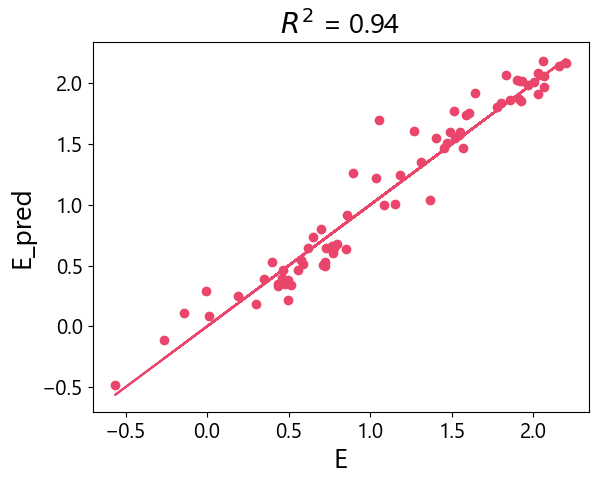

In [34]:
# 데이터를 분석합니다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json; import os; import pickle;

def find_rank(dictionary, key):
    target_value = dictionary[key]
    sorted_values = sorted(dictionary.values(), reverse=True)
    rank = sorted_values.index(target_value) + 1
    return rank

def calculate_r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ssr = np.sum((y_pred - y_true) ** 2)
    sst = np.sum((y_true - mean_y) ** 2)
    r_squared = 1 - (ssr / sst)
    return r_squared

df = pd.read_excel(file_select)
# Step 3: 'M' 열 제거
df = df.drop('M', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.
df = df.drop('index', axis=1)  # 'M'은 실제로 해당 열의 이름이어야 합니다.


# Step 4: 'G_Cl' 열을 예측 변수로 설정
y = df['G(Cl)']  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.
X = df.drop('G(Cl)', axis=1)  # 'G_Cl'은 실제로 해당 열의 이름이어야 합니다.

column_names = X.columns.to_list()
column_dict = {i:name for i, name in enumerate(column_names)}

X_np = X.values.astype('float32')
y_np = y.values.astype('float32').reshape(-1,1)

X_min = X_np.min(axis=0)
X_max = X_np.max(axis=0)

feat_min_max = {column_dict[i] : min_max for i,min_max in enumerate(zip(X_min,X_max))}

with open("./best_exp.txt","r") as f:
    bext_exp = f.readline()

for dir_path, dir_name, file_name in os.walk(os.getcwd()):
    if not "outputs" in dir_path.split("\\")[-1]:
        continue

    with open(os.path.join(dir_path,"model.pickle"),"rb") as f:
        model = pickle.load(f)

    with open(os.path.join(dir_path,"feature_weights.json"),"r") as f:
        feature_weights = json.load(f)
        
    y_pred = model.predict(X_np)
    R2 = calculate_r_squared(y_np,y_pred)
    plt.plot(y_np,y_np,color=colors[2])
    plt.scatter(y_np, y_pred,color=colors[0])
    plt.title(f'$R^2$ = {R2:.2f}',fontproperties=title_font_style)
    plt.xticks(fontproperties=tick_font_style)
    plt.yticks(fontproperties=tick_font_style)
    plt.xlabel('E',fontproperties=label_font_style)
    plt.ylabel('E_pred',fontproperties=label_font_style)
    plt.savefig(os.path.join(dir_path,f'parity_curve.png'))
    plt.show()
    plt.close()


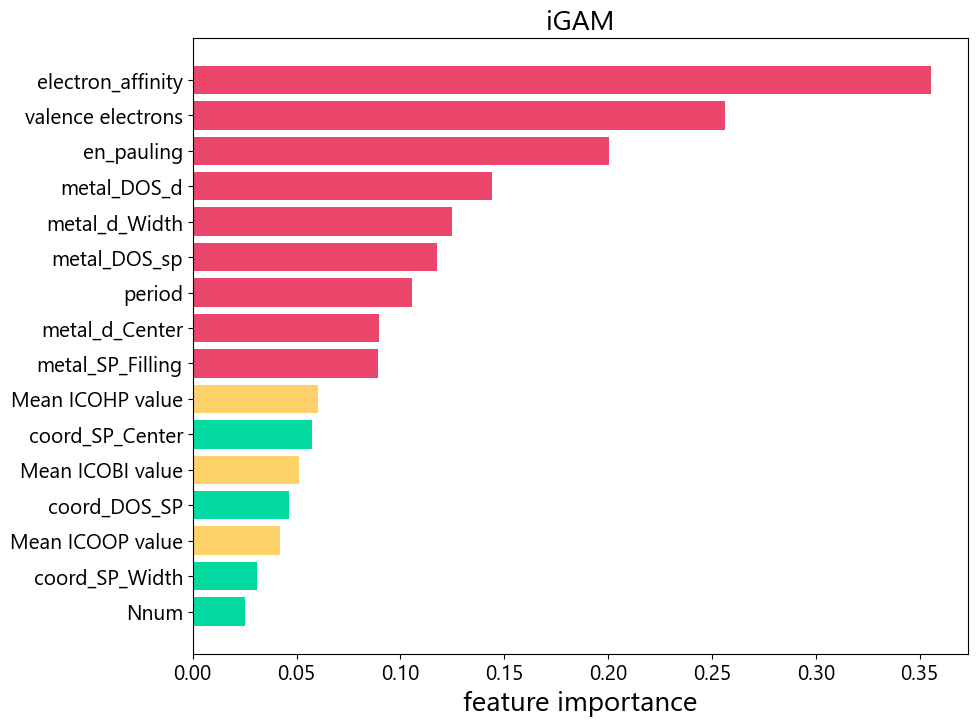

In [35]:
import json
import matplotlib.pyplot as plt

with open("./best_exp.txt","r") as f:
    best_exp = f.readline()[:-1]

with open(f"./outputs{best_exp}/feature_weights.json","r") as f:
    weights = json.load(f)

x = list(weights.keys())
y = list(weights.values())
plt.figure(figsize=(10,8)) # Adjust size as needed

sorted_data = sorted(zip(x, y), key=lambda item: item[1], reverse=False)
sorted_x, sorted_y = zip(*sorted_data)
sorted_colors = [feature_colors[name] for name in sorted_x]

plt.barh(sorted_x, sorted_y, color=sorted_colors)

plt.xticks(fontproperties=tick_font_style)
plt.yticks(fontproperties=tick_font_style)

plt.title('iGAM',fontproperties=title_font_style)
plt.xlabel("feature importance", fontproperties=label_font_style)

plt.savefig("./iGAM_feature_weights")


In [36]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from sklearn.metrics import mean_squared_error
import shap
def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """
    
    baseline_score_train = mean_squared_error(y, model.predict(X))
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)
    
    return baseline_score_train - permuted_score_train

def get_score_after_permutation(model, X, y, curr_feat):
    """ permute the values of the selected feature and calculate the score """
    X_permuted = X.copy()
    X_permuted[curr_feat] = np.random.permutation(X[curr_feat].values)
    permuted_score_train = mean_squared_error(y, model.predict(X_permuted.values))  # Here we convert DataFrame to numpy array
    
    return permuted_score_train



  0%|          | 0/72 [00:00<?, ?it/s]

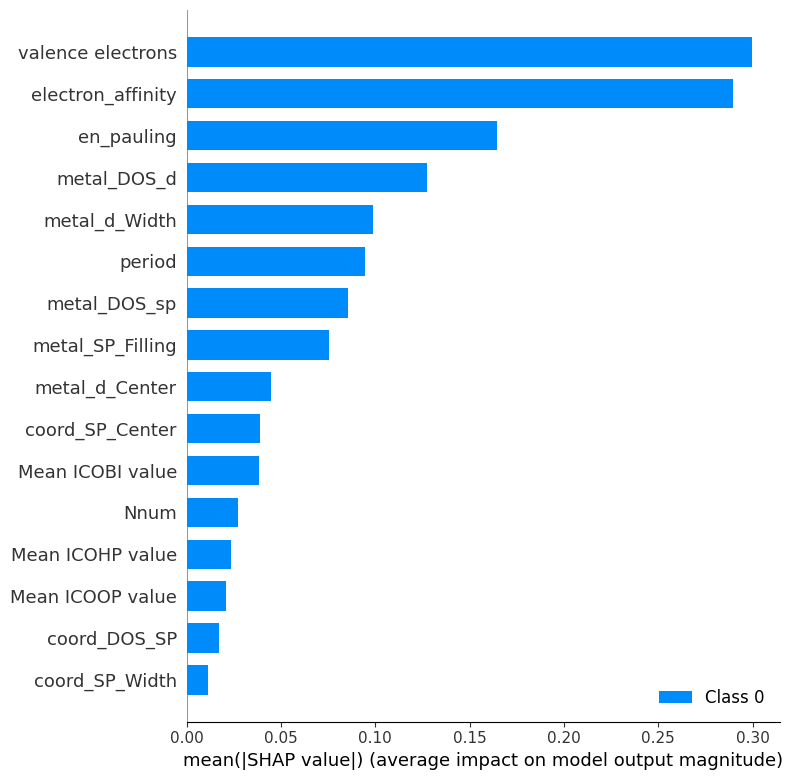

In [43]:
X_test_df = pd.DataFrame(X_np, columns=column_names[:X_np.shape[1]])

# Define the explainer
explainer = shap.KernelExplainer(model.predict, X_test_df)

# Calculate the SHAP values
shap_values = explainer.shap_values(X_test_df)

# Plot the summary
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


In [46]:
avg_shap_values = np.abs(shap_values).mean(axis=0)
mean=avg_shap_values.mean
print(mean)

<built-in method mean of numpy.ndarray object at 0x7f0179e4f630>


In [50]:
# Create DataFrame from X_np
X_test_df = pd.DataFrame(X_np, columns=column_names[:X_np.shape[1]])

# Define the explainer
explainer = shap.KernelExplainer(model.predict, X_test_df)

# Calculate the SHAP values

# Calculate the average SHAP values
avg_shap_values = np.abs(shap_values).mean(axis=0)

# Get the sort order
sort_order = np.argsort(avg_shap_values)

# Sort the feature names and colors
sorted_names = list(X_test_df.columns[sort_order])
sorted_colors = [feature_colors[name] for name in sorted_names]

# Generate the bar plot
plt.figure(figsize=(10,8)) # Adjust size as needed
plt.barh(sorted_names, avg_shap_values[sort_order], color=sorted_colors)

# Set the title and labels
fs = 20 # title size
fss = 15 # xlabel size
plt.title('Mean SHAP Importance', fontsize=fs)
plt.xlabel("Mean Feature Importance", fontsize=fss)

# Save the plot
plt.savefig('./mean_SHAP_importance.png', bbox_inches='tight')

# Show the plot
plt.show()


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


TypeError: ignored

In [47]:
fs = 20 # 타이틀 크기
fss = 15 # xlabel 크기
avg_shap_values = np.abs(shap_values).mean(axis=0)
mean=avg_shap_values.mean
# Create a plot for each class
for i, class_shap_values in enumerate(avg_shap_values):
    # Get the sort order
    sort = np.argsort(class_shap_values)

    # Sort the feature names and colors
    sorted_names = X_test_df.columns[sort]
    sorted_colors = [feature_colors[name] for name in sorted_names]

    # Generate the bar plot
    plt.figure(figsize=(10,8)) # Adjust size as needed
    plt.barh(sorted_names, class_shap_values[sort], color=sorted_colors)

    # Set the title and labels
    plt.title(f'SHAP Importance for Class {i}', fontsize=fs)
    plt.xlabel("Feature Importance", fontsize=fss)

    # Save the plot
    plt.savefig(f'./SHAP_class_{i}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

TypeError: ignored

In [ ]:
fs = 20 # 타이틀 크기
fss = 15 # xlabel 크기
avg_shap_values = np.abs(shap_values).mean(axis=0)

# Create 3x3 subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

# Flatten the axes array so we can use a simple loop
axs = axs.flatten()
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over each class
for i, class_shap_values in enumerate(avg_shap_values):
    # Get the sort order
    sort = np.argsort(class_shap_values)

    # Sort the feature names and colors
    sorted_names = X_test_df.columns[sort]
    sorted_colors = [feature_colors[name] for name in sorted_names]

    # Generate the bar plot on the appropriate subplot
    axs[i].barh(sorted_names, class_shap_values[sort], color=sorted_colors)
    axs[i].tick_params(labelsize=tick_font_style.get_size())  

    # Set the title and labels
    axs[i].set_title(f'SHAP Importance for Class {i}', fontsize=fs)
    axs[i].set_xlabel("Feature Importance", fontsize=fss)

# Delete the last two subplots
fig.delaxes(axs[7])
fig.delaxes(axs[8])

plt.tight_layout()

# Save the plot
plt.savefig('./SHAP_subplots.png', bbox_inches='tight')

# Show the plot
plt.show()
